# 2013-2017 American Community Survey (ACS) five-year estimates 

By [Christine Zhang](mailto:czhang@baltsun.com)

## Broadband subscriptions

## Data cleaning and analysis
### Import R data analysis libraries

In [5]:
suppressMessages(library('tidyverse'))
suppressMessages(library('tidycensus'))
suppressMessages(library('viridis'))
suppressMessages(library('sf'))

### "Maryland has the seventh-highest broadband subscription rates in the nation, with 82.8 percent of households having broadband connections. That’s more than the national average of 78 percent."

We will use the `tidycensus` package by [Kyle Walker](https://twitter.com/kyle_e_walker) to get broadband subscription rates at the state level (you'll need an API Key from http://api.census.gov/data/key_signup.html). For more about `tidycensus`, click [here](https://walkerke.github.io/tidycensus/index.html). For more about Census APIs, click [here](https://www.census.gov/data/developers/data-sets.html).

In [53]:
broadband.states <- get_acs(geography = 'state', year = 2017, variables = c('DP02_0152P'))

Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile


In [54]:
broadband.states <- broadband.states %>% arrange(desc(estimate)) %>% mutate(rank = rank(-estimate))
broadband.states %>% head(7)

GEOID,NAME,variable,estimate,moe,rank
33,New Hampshire,DP02_0152P,84.6,0.4,1
53,Washington,DP02_0152P,84.3,0.2,2
08,Colorado,DP02_0152P,83.8,0.2,3
49,Utah,DP02_0152P,83.7,0.3,4
25,Massachusetts,DP02_0152P,83.0,0.1,5
02,Alaska,DP02_0152P,82.9,0.4,6
24,Maryland,DP02_0152P,82.8,0.2,7


Maryland ranks seventh-highest in broadband subscription rates for the 2012-13 ACS period. To get the U.S. broadband subscription rate, we can pass the same parameters to `get_acs()` except for geography, which we will change to `geography = 'us'`.

In [55]:
broadband.us <- get_acs(geography = 'us', year = 2017, variables = c('DP02_0152P'))
broadband.us

Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile


GEOID,NAME,variable,estimate,moe
1,United States,DP02_0152P,78.1,0.1


In [57]:
print(paste("Maryland's broadband subscription rate is",  
            broadband.states[broadband.states$NAME == 'Maryland', ]$estimate, "percent, making it number", 
            broadband.states[broadband.states$NAME == 'Maryland', ]$rank,
            "in the nation. The national broadband subscription rate is",
            broadband.us$estimate, "percent."))

[1] "Maryland's broadband subscription rate is 82.8 percent, making it number 7 in the nation. The national broadband subscription rate is 78.1 percent."


### "69.5 percent of Baltimore’s households have broadband access, making the city one of ten counties with subscription rates that are below the state and national average."

To get the broadband subscription rate by county, we can pass the same parameters to `get_acs()` except for geography, which we will change to `geography = 'county'`. We'll also add `state = MD` to get just the counties in Maryland.

In [69]:
broadband.counties <- get_acs(geography = 'county', state = 'MD', year = 2017, variables = c('DP02_0152P'))

Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile


Use `mutate()` and `filter()` to find counties where broadband subscription rates are below the state and national averages.

In [70]:
broadband.counties <- broadband.counties %>% mutate(below_state_avg = ifelse(estimate < broadband.states[broadband.states$NAME == 'Maryland', ]$estimate, 
                                                                             1, 0),
                                                    below_nation_avg = ifelse(estimate < broadband.us$estimate, 
                                                                             1, 0))

In [81]:
below.avg <- broadband.counties %>% filter(below_state_avg == 1 & below_nation_avg == 1) %>% arrange(desc(estimate)) %>%
             mutate(rank_row = row_number())

In [80]:
print(paste(below.avg[below.avg$NAME == 'Baltimore city, Maryland',]$estimate,
            'percent of Baltimore’s households have broadband access. Including Baltimore, there are',
            max(below.avg$rank_row), 
            'counties in Maryland with subscription rates that are below the state and national average.'))

[1] "69.5 percent of Baltimore’s households have broadband access. Including Baltimore, there are 10 counties in Maryland with subscription rates that are below the state and national average."


### "Garrett and Somerset are the only counties with lower broadband subscription rates than Baltimore, at 68.9 and 63.8 percent, respectively."

In [82]:
below.avg

GEOID,NAME,variable,estimate,moe,below_state_avg,below_nation_avg,rank_row
24047,"Worcester County, Maryland",DP02_0152P,76.9,1.6,1,1,1
24045,"Wicomico County, Maryland",DP02_0152P,75.6,1.7,1,1,2
24011,"Caroline County, Maryland",DP02_0152P,72.8,2.2,1,1,3
24029,"Kent County, Maryland",DP02_0152P,72.6,3.2,1,1,4
24043,"Washington County, Maryland",DP02_0152P,72.4,1.3,1,1,5
24019,"Dorchester County, Maryland",DP02_0152P,70.5,2.6,1,1,6
24001,"Allegany County, Maryland",DP02_0152P,70.4,1.4,1,1,7
24510,"Baltimore city, Maryland",DP02_0152P,69.5,0.6,1,1,8
24023,"Garrett County, Maryland",DP02_0152P,68.9,2.3,1,1,9
24039,"Somerset County, Maryland",DP02_0152P,63.8,3.5,1,1,10


In [86]:
print(paste('Garrett County has a broadband subscription rate of',
            below.avg[below.avg$NAME == 'Garrett County, Maryland',]$estimate,
            'percent. Somerset County has a broadband subscription rate of',
            below.avg[below.avg$NAME == 'Somerset County, Maryland',]$estimate, 'percent.'))

[1] "Garrett County has a broadband subscription rate of 68.9 percent. Somerset County has a broadband subscription rate of 63.8 percent."


## Data visualization

We can use the `geometry = T` parameter to make a map of broadband subscription rates at the Census tract level.

In [129]:
options(tigris_use_cache = TRUE)

# get the county fips codes and save them into `cty_fips`
counties = broadband.counties %>% mutate(cty_fips = str_sub(broadband.counties$GEOID, 3)) %>%
                                  select(GEOID, NAME, cty_fips)

get_tracts <- function (cty) {
    
    df <- get_acs(geography = 'tract', state = 'MD', year = 2017, 
                  county = cty,
                  variables = c('DP02_0152P'), 
                  geometry = T)
    
    return(df)
    
    }

tracts_data_list <- lapply(counties$cty_fips, get_tracts)

Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile
Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile
Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile
Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile
Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile
Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile
Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile
Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile
Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile
Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile
Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile
Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile
Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile
Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile
Getting data from th

In [130]:
tracts_data_df <- data.frame(Reduce(rbind, tracts_data_list))

In [141]:
head(tracts_data_df)

GEOID,NAME,variable,estimate,moe,geometry
24001000300,"Census Tract 3, Allegany County, Maryland",DP02_0152P,67.3,7.6,MULTIPOLYGON (((-78.78853 3...
24001001800,"Census Tract 18, Allegany County, Maryland",DP02_0152P,78.4,5.2,MULTIPOLYGON (((-78.96104 3...
24001000100,"Census Tract 1, Allegany County, Maryland",DP02_0152P,63.3,6.9,MULTIPOLYGON (((-78.66654 3...
24001000800,"Census Tract 8, Allegany County, Maryland",DP02_0152P,66.6,7.5,MULTIPOLYGON (((-78.77848 3...
24001000500,"Census Tract 5, Allegany County, Maryland",DP02_0152P,63.6,9.5,MULTIPOLYGON (((-78.75836 3...
24001000700,"Census Tract 7, Allegany County, Maryland",DP02_0152P,58.1,8.6,MULTIPOLYGON (((-78.76509 3...


Static map

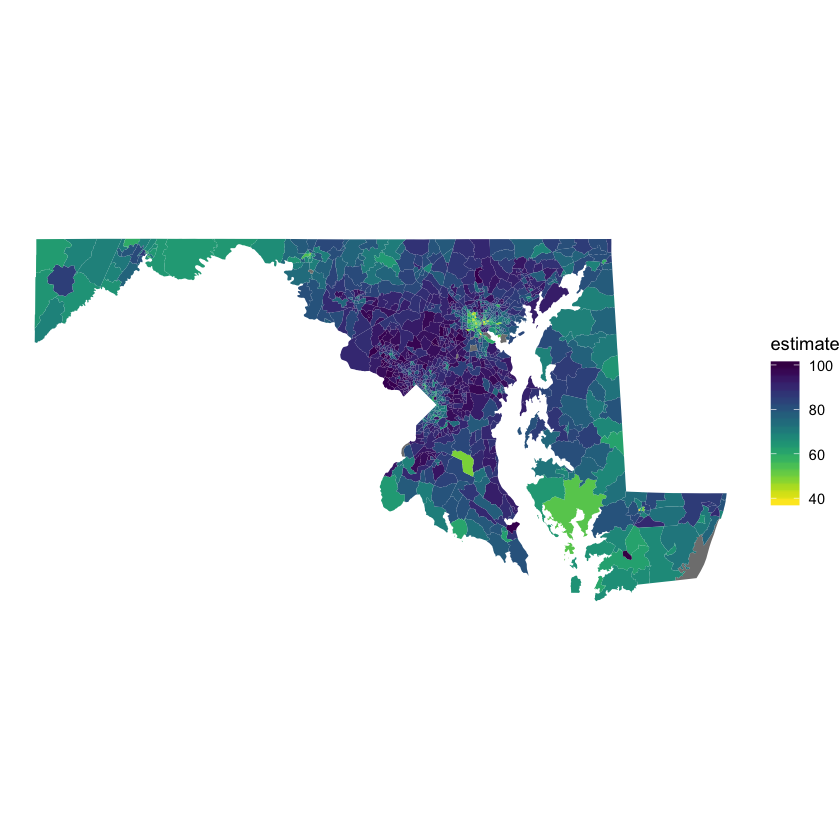

In [157]:
ggplot(tracts_data_df, aes(fill = estimate)) + geom_sf(color = 'white', size = 0) +
  coord_sf(crs = st_crs(4326)) + 
  scale_fill_viridis(direction=-1) +
  theme_void() +
  theme(panel.grid.major = element_line(colour = 'transparent')) 

We will read in Maryland's zip codes shapefiles. The zip codes shapefile is from Maryland's [GIS Data Catalog](http://data.imap.maryland.gov/datasets/maryland-political-boundaries-zip-codes-5-digit). These files can be found in the `input` folder (they must be unzipped prior to reading in).

This will allow us to figure out which zip codes fall in each of the census tracts using the `st_intersection()` function in the `sf` package.

In [153]:
zip_codes <- st_read("input/Maryland_Political_Boundaries__ZIP_Codes__5_Digit/Maryland_Political_Boundaries__ZIP_Codes__5_Digit.shp", 
                     quiet = TRUE)

tracts_data_df <- st_as_sf(tracts_data_df) %>% st_set_crs(4326)

In [163]:
intersection <- st_intersection(zip_codes, tracts_data_df)

intersection <- intersection %>% select(GEOID, ZIPCODE1) %>% as.data.frame() 
intersection <- intersection %>% select(-geometry)
intersection <- intersection %>% group_by(GEOID) %>% mutate(number = row_number()) %>% arrange(GEOID)

# wide format with just one column for zipcodes
intersection.wide <- intersection %>% group_by(GEOID) %>%
  summarize_all(paste, collapse=", ") %>% select(-number) %>% rename(zipcode = ZIPCODE1)

although coordinates are longitude/latitude, st_intersection assumes that they are planar
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”

In [168]:
tracts_data_df_zip <- merge(tracts_data_df, intersection.wide, by = 'GEOID')

st_write(tracts_data_df_zip, 'output/broadband_census_tracts.shp')

Writing layer `broadband_census_tracts' to data source `output/broadband_census_tracts.shp' using driver `ESRI Shapefile'
features:       1394
fields:         6
geometry type:  Multi Polygon
